In [1]:
import cv2
import numpy as np
import torch
import pandas as pd
import face_recognition
import matplotlib.pyplot as plt
import os
import time
import csv


In [10]:
!pip3 list

Package                 Version
----------------------- --------------------
absl-py                 0.13.0
apturl                  0.5.2
astroid                 3.2.4
asttokens               2.4.1
astunparse              1.6.3
atomicwrites            1.1.5
attrs                   19.3.0
backcall                0.2.0
bcrypt                  3.1.7
beautifulsoup4          4.8.2
black                   24.8.0
blinker                 1.4
Brlapi                  0.7.0
cachetools              4.2.2
certifi                 2019.11.28
chardet                 3.0.4
charset-normalizer      2.0.6
click                   8.1.7
cmake                   3.30.5
colorama                0.4.3
comm                    0.2.2
command-not-found       0.3
cryptography            2.8
cupshelpers             1.0
cycler                  0.10.0
Cython                  3.0.11
dbus-python             1.2.16
debugpy                 1.8.7
decorator               4.4.2
defer                   1.0.6
dill               

In [9]:
cv2.__version__


'4.8.0'

In [ ]:
class Face:
    """Class for worked camera on jetson nano"""
    def __init__(self, sensor_id=0, cap_width = 780, cap_height=480, d_width=780, d_height=480, framerate=30, flip_method=0):
        """Initialize setting for camera in class"""
        self.sensor_id=sensor_id
        self.capture_width=cap_width  #1920
        self.capture_height=cap_height  #1080
        self.display_width=d_width
        self.display_height=d_height
        self.framerate=framerate
        self.flip_method=flip_method
        self.name_csv = "emb.csv"
        self.path_root = "person/"
        #create csv if not file
        if not os.path.isfile(os.path.join(self.path_root, self.name_csv)):
            with open(os.path.join(self.path_root, self.name_csv), 'w', newline='') as file:
                writer = csv.writer(file)
                field = ['name', 'embedding']
                writer.writerow(field)

    def gstreamer_pipeline(self):
        """Initialize from gstreamer driver camera"""
        return (
            "nvarguscamerasrc sensor-id=%d ! "
            "video/x-raw(memory:NVMM), width=(int)%d, height=(int)%d, framerate=(fraction)%d/1 ! "
            "nvvidconv flip-method=%d ! "
            "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
            "videoconvert ! "
            "video/x-raw, format=(string)BGR ! appsink"
            % (
                self.sensor_id,
                self.capture_width,
                self.capture_height,
                self.framerate,
                self.flip_method,
                self.display_width,
                self.display_height,
            )
        )
    
    def save_face(self, name=""):
        """write embedding face and name one a person for recognition to csv file"""
        embed_person = 0
        cap = cv2.VideoCapture(self.gstreamer_pipeline(), cv2.CAP_GSTREAMER) # opened camera
        print(self.gstreamer_pipeline())
        print(f'CAP: ', cap.isOpened())
        try:
            if cap.isOpened():
                ret, frame = cap.read() # get image from camera
                if ret:
                    frame_rz = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
                    img = cv2.cvtColor(frame_rz, cv2.COLOR_BGR2RGB)
                    # process name
                    if name == "":
                        name = 'Not input Name'
                    else:
                        name = name
                    # process image
                    location_face = face_recognition.face_locations(img)
                    embedding = face_recognition.face_encodings(img, location_face)
                    #
                    load_faces = pd.read_csv(os.path.join(self.path_root, self.name_csv), converters={'embedding': eval}).reset_index()
                    names = list(load_faces['name'])

                    if embedding:
                        embed_person = embedding[0]
                        if load_faces.size > 0:
                            for i in range(load_faces.shape[0]):
                                save_emb_faces = np.array(load_faces['embedding'].iloc[i], dtype=np.float64)
                            
                                matches = face_recognition.compare_faces(embed_person[None,], save_emb_faces[None,]) #!
                                if matches and name in names:
                                    print(f'Such a person with name {name} is face already exists!!!')
                                    break
                        else:
                        
                            print(f'Ok embedding by a name {name}!')
                            if name != "" and embed_person.size > 0:
                    
                                data = pd.DataFrame({
                                    "name": [name],
                                    "embedding": [embed_person.tolist()]
                                })
                                data.to_csv(os.path.join(self.path_root, self.name_csv), index=False, mode='a',
                                            header=not os.path.exists(os.path.join(self.path_root, self.name_csv)))
                            plt.imshow(frame[:,:,::-1])
                            plt.title(f'{name}')
                            plt.show()
                else:
                        embed_person = 0
                        print(f'Not getting embebbing face for name: {name}(')

        except Exception as e:
            print("Not opened camera, error: ", e)
            
        finally:
            cap.release()
            cv2.destroyAllWindows()
    
    def show_camera(self):
        """Inference imaging recognizing face"""
        video = cv2.VideoCapture(self.gstreamer_pipeline(), cv2.CAP_GSTREAMER)
        print(video.isOpened())
        if video.isOpened():
            try:
                while True:
                    ret, frame = video.read()
                    if not ret:
                        print("Not get frame!")
                        break

                    # frame resize
                    frame_rsz = cv2.resize(frame, (0, 0), fx=0.2, fy=0.2)

                    # frame convert from bgr to rgb
                    frame_rgb = cv2.cvtColor(frame_rsz, cv2.COLOR_BGR2RGB)
 
                    # face_recognition all person                                         
                    locations_face = face_recognition.face_locations(frame_rgb)
                    embeddings_face = face_recognition.face_encodings(frame_rsz, locations_face)

                    # read saves  embeddings faces
                    faces_name = []
                    get_location_faces = [] 
                    # name_u = 'Unknow'
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    save_embed = 0
                    loaded_data = pd.read_csv(os.path.join(self.path_root, self.name_csv), converters={'embedding': eval}).reset_index()

                    for embedding_face, location_face in zip(embeddings_face, locations_face):
                        found_match = False # flag for matching face
                        for i in range(loaded_data.shape[0]):
                            name = loaded_data['name'].iloc[i]
                            save_embed = np.array(loaded_data['embedding'].iloc[i], dtype = np.float64)

                            #matching embeddings
                            matches_face = face_recognition.compare_faces(embedding_face[None], save_embed[None,], tolerance=0.6)
                            if matches_face[0]:
                                faces_name.append(name)
                                get_location_faces.append(location_face)
                                found_match = True
                                break
                        # if not matching found, face as Unknow
                        if not found_match:
                            faces_name.append('Unknow')
                            get_location_faces.append(location_face)

                    for (top, right, bottom, left), name_v in zip(get_location_faces, faces_name):
                        top *= 5
                        right *= 5
                        bottom *= 5
                        left *= 5
                        color = (0, 255, 0) if name_v != "Unknow" else (255, 0, 0)
                        cv2.rectangle(frame, (left, top), (right, bottom), color, 1)
                        cv2.putText(frame, name_v, (left, top - 10), font, 1.0, (255, 255, 255), 1)

                    cv2.imshow(f'Video', frame)
                   
                    keyCode = cv2.waitKey(10) & 0xFF
                    if keyCode == 27 or keyCode == ord('q'):
                        break

            except Exception as e:
                print("Not open camera gstreamer for video exception: ", e)
            finally:
                video.release()
                cv2.destroyAllWindows()

    def delete_face(self, name=""):
        path_csv = os.path.join(self.path_root, self.name_csv)
        df_faces = pd.read_csv(path_csv, index_col=0).reset_index()
        len_start = df_faces.shape[0]
        # get index
        if name != "":
            idx = df_faces[df_faces['name'] == f'{name}'].index
            df_faces.drop(index=idx, inplace=True)
            len_end = df_faces.shape[0]
            if len_end < len_start:
                print(f"Delet {name} OK!")
            else:
                print(f'Not {name} deleted, may be there is no such name in save!')
            df_faces.to_csv(path_csv, index = False)
        else:
            print("Write name in delete_face('name') !")


face = Face()
# face.get_embedings('Andrey')

# face.show_camera()


Inference for UNKNOW face

In [16]:
face.show_camera()

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3264 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3264 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 120.000005 fps Duration = 8333333 ; Analog Gain range min 1.000000, max 10.625000; Exposur

[ WARN:0@1368.131] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


True
GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


Save face for recognize

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3264 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3264 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 120.000005 fps Duration = 8333333 ; Analog Gain range min 1.000000, max 10.625000; Exposur

[ WARN:0@1384.908] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


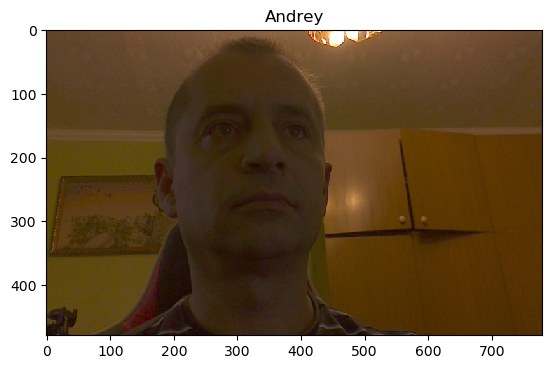

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [17]:
face.save_face('Andrey')

Inference for recognize saved a face

In [18]:
face.show_camera()

GST_ARGUS: Creating output stream
CONSUMER: Waiting until producer is connected...
GST_ARGUS: Available Sensor modes :
GST_ARGUS: 3264 x 2464 FR = 21.000000 fps Duration = 47619048 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 3264 x 1848 FR = 28.000001 fps Duration = 35714284 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1920 x 1080 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1640 x 1232 FR = 29.999999 fps Duration = 33333334 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 59.999999 fps Duration = 16666667 ; Analog Gain range min 1.000000, max 10.625000; Exposure Range min 13000, max 683709000;

GST_ARGUS: 1280 x 720 FR = 120.000005 fps Duration = 8333333 ; Analog Gain range min 1.000000, max 10.625000; Exposur

[ WARN:0@1397.406] global cap_gstreamer.cpp:1728 open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


Deleting a saved face

In [19]:
face.delete_face('Andrey')

Delet Andrey OK!


In [6]:

path_csv = 'person/emb.csv'
data = {}
name = ''
embed = 0
loaded_data = pd.read_csv(path_csv, index_col = 0).reset_index()
loaded_data.head()




,name,embedding
0,Alexandra,"[-0.09881811589002609, 0.030009131878614426, 0..."
1,Andrey,"[0.013003166764974594, 0.13323459029197693, 0...."


In [38]:
idx = loaded_data[loaded_data['name'] == 'Andrey_2'].index
loaded_data.drop(index=idx, inplace=True)
loaded_data.to_csv(path_csv, index=False)
loaded_data.head()

,name,embedding
1,AndreyM,"[-0.0673091784119606, 0.07660961151123047, 0.0..."


In [13]:
df = pd.read_csv(path_csv, index_col=0).reset_index()
names = list(df['name'])
names

['Alexandra', 'Andrey']

In [4]:
a = []
name = ['u']
count = 2
#a.append(name)
#[a.append(name) for _ in range(count)]
a = name * count
a

['u', 'u']

In [39]:
locate = (26, 112, 70, 69)
for i, i1, i2, i3 in [locate]:
    print(i, i1, i2, i3)

26 112 70 69
